In [3]:
print("Hell Bitter  Byte")

Hell Bitter  Byte


In [4]:
# Import our dependencies
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as skl
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from keras.layers import Dropout

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pyspark.sql import SparkSession

In [5]:
from sqlalchemy import create_engine
# Create a reference to the file.
database_path = Path("SBADATA.sqlite")
# Create Engine
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()
# Query All Records in the the Database
df1 = pd.read_sql("SELECT * FROM SBA", conn)
df1

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,27-Feb-97,1997,...,0,N,,30-Sep-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00"
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,27-Feb-97,1997,...,Y,N,,31-Oct-97,"$85,000.00",$0.00,P I F,$0.00,"$85,000.00","$42,500.00"
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,27-Feb-97,1997,...,N,N,,30-Sep-97,"$300,000.00",$0.00,P I F,$0.00,"$300,000.00","$225,000.00"
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,27-Feb-97,1997,...,N,Y,8-Mar-00,31-Mar-97,"$75,000.00",$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00"


In [6]:
# loan_data = Path("SBAnational.csv")

# #Reading our data into pandas
# df1 = pd.read_csv(loan_data)
# df1.head()

In [7]:
df1.dtypes

LoanNr_ChkDgt        object
Name                 object
City                 object
State                object
Zip                  object
Bank                 object
BankState            object
NAICS                object
ApprovalDate         object
ApprovalFY           object
Term                 object
NoEmp                object
NewExist             object
CreateJob            object
RetainedJob          object
FranchiseCode        object
UrbanRural           object
RevLineCr            object
LowDoc               object
ChgOffDate           object
DisbursementDate     object
DisbursementGross    object
BalanceGross         object
MIS_Status           object
ChgOffPrinGr         object
GrAppv               object
SBA_Appv             object
dtype: object

In [8]:
#Removing the $ sign and comman to be able to convert the column into a string 
df1[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']] = df1[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))

In [9]:
df1['NAICS'] = pd.to_numeric(df1['NAICS'], errors='coerce')

In [10]:
df2 = df1.replace(0,pd.np.nan).dropna(axis = 0, how= 'any', subset="NAICS").fillna(0)


C:\Users\ljm47\AppData\Local\Temp\ipykernel_29896\1902025118.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df2 = df1.replace(0,pd.np.nan).dropna(axis = 0, how= 'any', subset="NAICS").fillna(0)


In [11]:
df2.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120.0,28-Feb-97,1997,...,N,Y,,28-Feb-99,60000.00,0.00,P I F,0.00,60000.00,48000.00
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410.0,28-Feb-97,1997,...,N,Y,,31-May-97,40000.00,0.00,P I F,0.00,40000.00,32000.00
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210.0,28-Feb-97,1997,...,N,N,,31-Dec-97,287000.00,0.00,P I F,0.00,287000.00,215250.00
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721.0,28-Feb-97,1997,...,N,N,,30-Jun-97,517000.00,0.00,P I F,0.00,517000.00,387750.00
7,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118.0,28-Feb-97,1997,...,N,Y,,30-Jun-98,45000.00,0.00,P I F,0.00,45000.00,36000.00


In [12]:
df2["Industry"] = df2['NAICS'].astype('str').str[:2]
df2.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120.0,28-Feb-97,1997,...,Y,,28-Feb-99,60000.00,0.00,P I F,0.00,60000.00,48000.00,45
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410.0,28-Feb-97,1997,...,Y,,31-May-97,40000.00,0.00,P I F,0.00,40000.00,32000.00,72
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210.0,28-Feb-97,1997,...,N,,31-Dec-97,287000.00,0.00,P I F,0.00,287000.00,215250.00,62
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721.0,28-Feb-97,1997,...,N,,30-Jun-97,517000.00,0.00,P I F,0.00,517000.00,387750.00,33
7,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118.0,28-Feb-97,1997,...,Y,,30-Jun-98,45000.00,0.00,P I F,0.00,45000.00,36000.00,81


In [13]:
df3 =df2.drop("NAICS", axis='columns')
df3.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,ApprovalDate,ApprovalFY,Term,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,28-Feb-97,1997,84,...,Y,,28-Feb-99,60000.00,0.00,P I F,0.00,60000.00,48000.00,45


In [14]:
df3['Industry'].value_counts()

44    84737
81    72618
54    68170
72    67600
23    66646
62    55366
42    48743
45    42514
33    38284
56    32685
48    20310
32    17936
71    14640
53    13632
31    11809
51    11379
52     9496
11     9005
61     6425
49     2221
21     1851
22      663
55      257
92      229
Name: Industry, dtype: int64

In [15]:
df4 = df2.copy()

industry_dict = {
    '11': 'Ag/Forest/Fish/Hunt',
    '21': 'Mining/Quar/Oil_Gas_ext',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale_trade',
    '44': 'Retail_trade',
    '45': 'Retail_trade',
    '48': 'Trans/Ware',
    '49': 'Trans/Ware',
    '51': 'Information',
    '52': 'Finance/Insurance',
    '53': 'RE/Rental/Lease',
    '54': 'Prof/Science/Tech',
    '55': 'Mgmt_comp',
    '56': 'Admin_sup/Waste_Mgmt_Rem',
    '61': 'Educational',
    '62': 'Healthcare/Social_assist',
    '71': 'Arts/Entertain/Rec',
    '72': 'Accom/Food_serv',
    '81': 'Other_no_pub',
    '92': 'Public_Admin'
}

df4['Industry'] = df4['Industry'].map(industry_dict)
df4.head(3)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120.0,28-Feb-97,1997,...,Y,,28-Feb-99,60000.00,0.00,P I F,0.00,60000.00,48000.00,Retail_trade
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410.0,28-Feb-97,1997,...,Y,,31-May-97,40000.00,0.00,P I F,0.00,40000.00,32000.00,Accom/Food_serv
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210.0,28-Feb-97,1997,...,N,,31-Dec-97,287000.00,0.00,P I F,0.00,287000.00,215250.00,Healthcare/Social_assist


In [16]:
df4['Industry'].value_counts()

Retail_trade                127251
Other_no_pub                 72618
Prof/Science/Tech            68170
Manufacturing                68029
Accom/Food_serv              67600
Construction                 66646
Healthcare/Social_assist     55366
Wholesale_trade              48743
Admin_sup/Waste_Mgmt_Rem     32685
Trans/Ware                   22531
Arts/Entertain/Rec           14640
RE/Rental/Lease              13632
Information                  11379
Finance/Insurance             9496
Ag/Forest/Fish/Hunt           9005
Educational                   6425
Mining/Quar/Oil_Gas_ext       1851
Utilities                      663
Mgmt_comp                      257
Public_Admin                   229
Name: Industry, dtype: int64

In [17]:
df4.dtypes

LoanNr_ChkDgt         object
Name                  object
City                  object
State                 object
Zip                   object
Bank                  object
BankState             object
NAICS                float64
ApprovalDate          object
ApprovalFY            object
Term                  object
NoEmp                 object
NewExist              object
CreateJob             object
RetainedJob           object
FranchiseCode         object
UrbanRural            object
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
Industry              object
dtype: object

In [18]:
df4['Zip'] = pd.to_numeric(df4['Zip'], errors='coerce')
df4['Term'] = pd.to_numeric(df4['Term'], errors='coerce')
df4['NoEmp'] = pd.to_numeric(df4['NoEmp'], errors='coerce')
df4['NewExist'] = pd.to_numeric(df4['NewExist'], errors='coerce')
df4['CreateJob'] = pd.to_numeric(df4['CreateJob'], errors='coerce')
df4['RetainedJob'] = pd.to_numeric(df4['RetainedJob'], errors='coerce')
df4['FranchiseCode'] = pd.to_numeric(df4['FranchiseCode'], errors='coerce')
df4['UrbanRural'] = pd.to_numeric(df4['UrbanRural'], errors='coerce')


df4['SBA_Appv'] = pd.to_numeric(df4['SBA_Appv'], errors='coerce')
df4['GrAppv'] = pd.to_numeric(df4['GrAppv'], errors='coerce')
df4['ChgOffPrinGr'] = pd.to_numeric(df4['ChgOffPrinGr'], errors='coerce')
df4['BalanceGross'] = pd.to_numeric(df4['BalanceGross'], errors='coerce')
df4['DisbursementGross'] = pd.to_numeric(df4['DisbursementGross'], errors='coerce')



In [19]:
df4["Bank"].isnull().sum()

0

In [20]:
df4.dtypes

LoanNr_ChkDgt         object
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                float64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross    float64
BalanceGross         float64
MIS_Status            object
ChgOffPrinGr         float64
GrAppv               float64
SBA_Appv             float64
Industry              object
dtype: object

In [21]:
df5 = df4.dropna(subset="MIS_Status")


In [22]:
df5.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120.0,28-Feb-97,1997,...,Y,,28-Feb-99,60000.0,0.0,P I F,0.0,60000.0,48000.0,Retail_trade
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410.0,28-Feb-97,1997,...,Y,,31-May-97,40000.0,0.0,P I F,0.0,40000.0,32000.0,Accom/Food_serv
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210.0,28-Feb-97,1997,...,N,,31-Dec-97,287000.0,0.0,P I F,0.0,287000.0,215250.0,Healthcare/Social_assist
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721.0,28-Feb-97,1997,...,N,,30-Jun-97,517000.0,0.0,P I F,0.0,517000.0,387750.0,Manufacturing
7,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118.0,28-Feb-97,1997,...,Y,,30-Jun-98,45000.0,0.0,P I F,0.0,45000.0,36000.0,Other_no_pub


In [23]:
# df5.to_csv("dataset_clean_1.csv",
#                   encoding="utf-8", index=False, header=True)

In [24]:
df5['MIS_Status'].value_counts()

P I F     554741
CHGOFF    140759
            1716
Name: MIS_Status, dtype: int64

In [25]:
mask = df5["MIS_Status"] == ""
df6 = df5[~mask]
df6['MIS_Status'].value_counts()

P I F     554741
CHGOFF    140759
Name: MIS_Status, dtype: int64

In [26]:
df7 = df6.copy()
status = {
    "P I F" : "0",
    "CHGOFF" : "1"
}
df7['MIS_Status'] = df7['MIS_Status'].map(status)

In [27]:
df7['MIS_Status'].value_counts()

0    554741
1    140759
Name: MIS_Status, dtype: int64

In [28]:
df7['MIS_Status'] = pd.to_numeric(df7['MIS_Status'], errors='coerce')

In [29]:
df7['MIS_Status'].value_counts()

0    554741
1    140759
Name: MIS_Status, dtype: int64

In [30]:
df7['Zip'].nunique

<bound method IndexOpsMixin.nunique of 0         47711
1         46526
2         47401
5          6062
7         34491
          ...  
899156    21224
899157    92020
899159    43221
899160    43221
899161    93455
Name: Zip, Length: 695500, dtype: int64>

In [31]:
print(df7.shape)
df7['Zip'] = pd.to_numeric(df4['Zip'], errors='coerce')
df8 = df7.loc[df7['Zip'] > 1000]
print(df8.shape)

(695500, 28)
(695260, 28)


In [32]:
# df99 = df8.dropna(subset="MIS_Status")

In [33]:
mask = df8["State"] == ""
df9 = df8[~mask]
df9.shape

(695252, 28)

In [34]:
mask = df9["City"] == "`"
df10 = df9[~mask]
df10.shape

(695248, 28)

In [35]:
mask = df10["Name"] == ""
df11 = df10[~mask]
df11.shape


(695247, 28)

In [36]:
mask = df11["Bank"] == ""
df12 = df11[~mask]
df12.shape

(694625, 28)

In [37]:
mask = df12["BankState"] == ""
df13 = df12[~mask]
df13.shape

(694622, 28)

In [38]:
#Selecting only term greater than 12 months for a loan 

df13['Term'] = pd.to_numeric(df13['Term'], errors='coerce')
df14 = df13.loc[df13['Term'] > 12]
print(df14.shape)

C:\Users\ljm47\AppData\Local\Temp\ipykernel_29896\3999961092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df13['Term'] = pd.to_numeric(df13['Term'], errors='coerce')


(662444, 28)


In [39]:
df14.shape

(662444, 28)

In [40]:
mask = df14["NewExist"] == 0
df15 = df14[~mask]
df15.shape

(661772, 28)

In [41]:
df15 = df15.dropna(subset="NewExist")
df15.shape

(661643, 28)

In [42]:
df16 = df15.copy()

In [43]:
# df16["IsFranchise"] = np.where((df16['FranchiseCode'] == 0 | df16['FranchiseCode']== 1 , 'N', 'Y'))
# df16['FranchiseCode'] = pd.to_numeric(df16['FranchiseCode'], errors='coerce')
df17 = df16.loc[df16['FranchiseCode'] <= 1]
df17.shape

(627426, 28)

In [44]:
df17.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'Industry'],
      dtype='object')

In [45]:
mask = df17["UrbanRural"] == 0
df18 = df17[~mask]
df18.shape

(495964, 28)

In [46]:
df19=df18.copy()

In [47]:
df20 = df19.loc[((df19['RevLineCr'] == 'Y') | (df19['RevLineCr'] == 'N')) ]

In [48]:
df20.shape

(322702, 28)

In [49]:
df21 = df20.loc[((df20['LowDoc'] == 'Y') | (df20['LowDoc'] == 'N'))]
df21.shape

(319365, 28)

In [50]:
df_tableau = df21.copy()

In [51]:
df22 = df21.drop(columns=['LoanNr_ChkDgt', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross','NAICS', 'ApprovalDate'])

In [52]:
df22.head(10)

,Name,City,State,Zip,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,...,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
24,SUBWAY,LITTLE ROCK,AR,72223,HOPE FCU,MS,2006,126,7,1.0,...,0,1,1,N,N,0,0.0,137300.0,116705.0,Accom/Food_serv
28,WEYLAND CORPORATION,CAMARILLO,CA,93010,WELLS FARGO BANK NATL ASSOC,SD,2006,83,18,2.0,...,23,1,1,Y,N,0,0.0,100000.0,50000.0,Educational
30,CHICAGO BRICK UNLIMITED INC,MIAMI,FL,33186,"CITIBANK, N.A.",FL,2006,84,4,1.0,...,4,1,1,Y,N,0,0.0,35000.0,17500.0,Construction
32,"RZI, INC.",NEW ORLEANS,LA,70130,BUSINESS RES. CAP. SPECIALTY B,LA,2006,60,3,1.0,...,0,1,1,N,N,0,0.0,50000.0,42500.0,RE/Rental/Lease
34,HUTMACHER HOLDINGS INC,LEANDER,TX,78641,WELLS FARGO BANK NATL ASSOC,SD,2006,80,2,1.0,...,6,1,2,Y,N,0,0.0,25000.0,12500.0,Prof/Science/Tech
65,B&B DIPNETS,WASILLA,AK,99654,WELLS FARGO BANK NATL ASSOC,SD,2006,83,2,1.0,...,2,1,1,Y,N,0,0.0,30000.0,15000.0,Manufacturing
67,LILY DAY GARDENS,BURNET,TX,78611,WELLS FARGO BANK NATL ASSOC,SD,2006,26,4,2.0,...,5,1,2,Y,N,1,19994.0,20000.0,10000.0,Retail_trade
77,TULON PACIFIC LLC,IRVINE,CA,92618,WELLS FARGO BANK NATL ASSOC,SD,2006,36,18,1.0,...,19,1,1,Y,N,0,0.0,300000.0,150000.0,Wholesale_trade
89,SHAFI SECURITY,THORNTON,CO,80602,JPMORGAN CHASE BANK NATL ASSOC,IL,2006,54,4,1.0,...,4,1,2,Y,N,1,28979.0,30000.0,15000.0,Admin_sup/Waste_Mgmt_Rem
123,ONE BITE JAPANESE GRILL,OVERLAND PARK,KS,66213,VALLEY VIEW STATE BANK,KS,2006,60,8,2.0,...,0,1,1,N,N,0,0.0,95000.0,80750.0,Accom/Food_serv


In [53]:
df22.dtypes

Name              object
City              object
State             object
Zip                int64
Bank              object
BankState         object
ApprovalFY        object
Term               int64
NoEmp              int64
NewExist         float64
CreateJob          int64
RetainedJob        int64
FranchiseCode      int64
UrbanRural         int64
RevLineCr         object
LowDoc            object
MIS_Status         int64
ChgOffPrinGr     float64
GrAppv           float64
SBA_Appv         float64
Industry          object
dtype: object

In [54]:
df22["MIS_Status"].value_counts()

0    238121
1     81244
Name: MIS_Status, dtype: int64

C:\Users\ljm47\AppData\Local\Temp\ipykernel_29896\1013323277.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_relation = df22.corr()
C:\Users\ljm47\AppData\Local\Temp\ipykernel_29896\1013323277.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  g= sns.heatmap(df4[top_relations].corr(), annot=True)


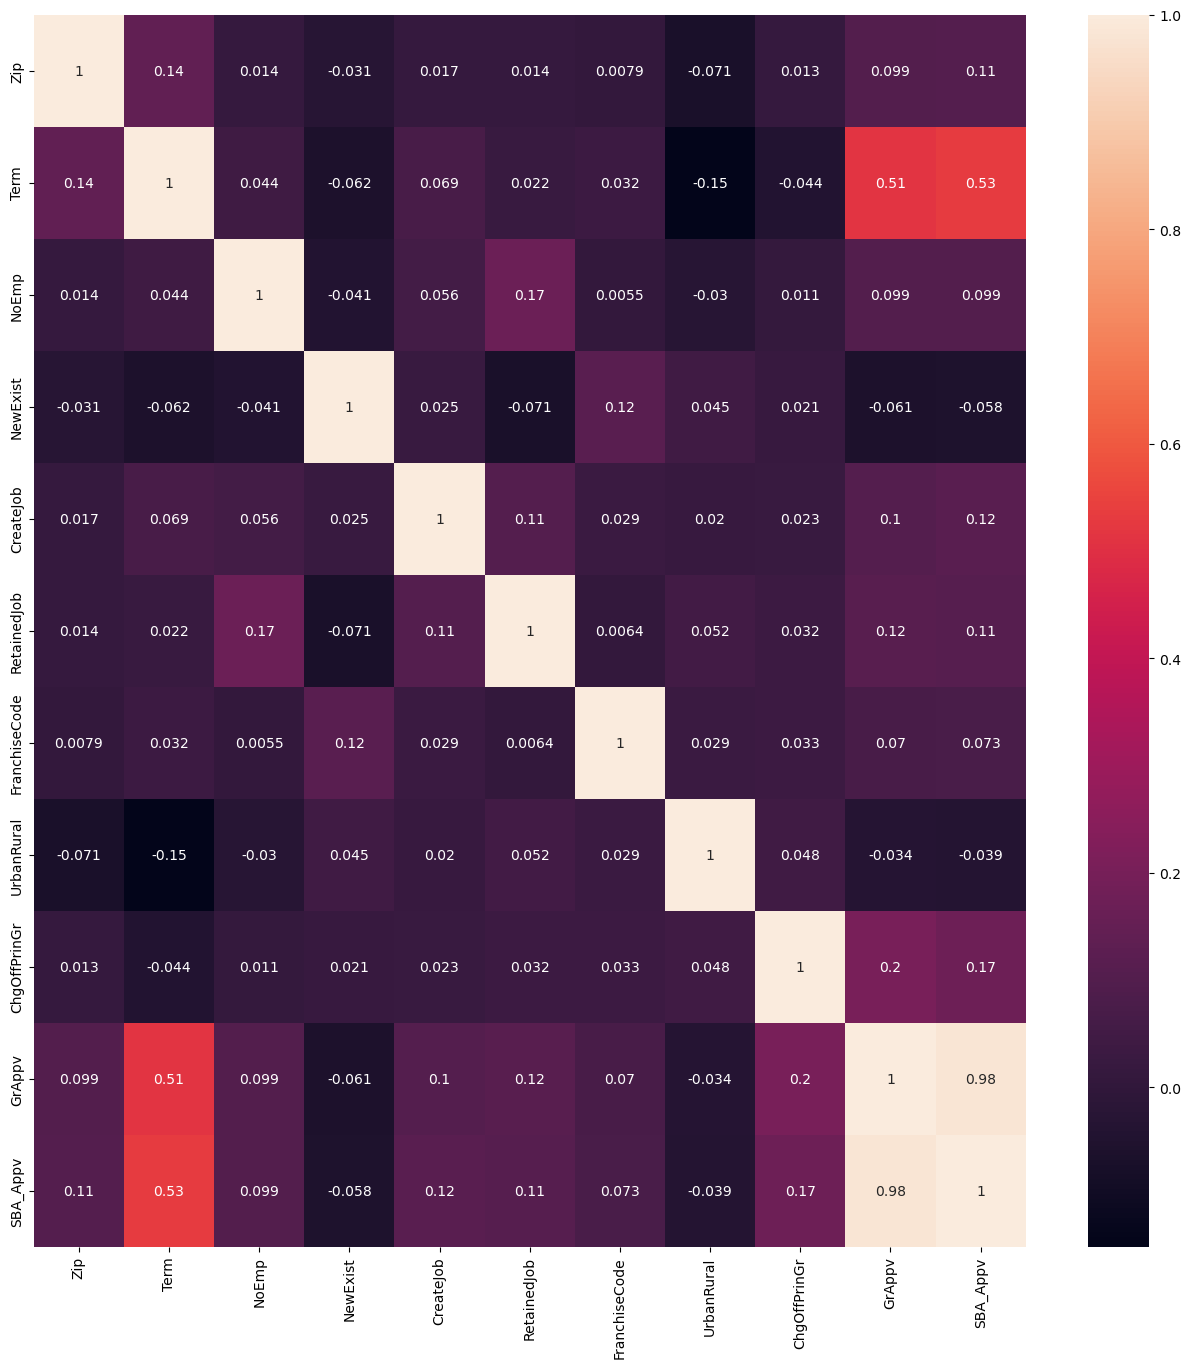

In [55]:
import seaborn as sns
cor_relation = df22.corr()
cor_relation
top_relations = cor_relation.index
plt.figure(figsize=(16,16))
g= sns.heatmap(df4[top_relations].corr(), annot=True)
plt.show()

In [56]:
df22["MIS_Status"].value_counts()

0    238121
1     81244
Name: MIS_Status, dtype: int64

In [57]:
df22.columns

Index(['Name', 'City', 'State', 'Zip', 'Bank', 'BankState', 'ApprovalFY',
       'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'MIS_Status',
       'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'Industry'],
      dtype='object')

In [58]:
df23 = df22.drop(columns=['ChgOffPrinGr', 'Name', 'City', 'Zip', 'Bank','BankState', 'BankState', 'SBA_Appv', 'ApprovalFY'])#dropping these columns  as they are not required for ML

In [59]:
df23.head()

,State,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,Industry
24,AR,126,7,1.0,0,0,1,1,N,N,0,137300.0,Accom/Food_serv
28,CA,83,18,2.0,5,23,1,1,Y,N,0,100000.0,Educational
30,FL,84,4,1.0,0,4,1,1,Y,N,0,35000.0,Construction
32,LA,60,3,1.0,0,0,1,1,N,N,0,50000.0,RE/Rental/Lease
34,TX,80,2,1.0,4,6,1,2,Y,N,0,25000.0,Prof/Science/Tech


In [60]:
df23.dtypes

State             object
Term               int64
NoEmp              int64
NewExist         float64
CreateJob          int64
RetainedJob        int64
FranchiseCode      int64
UrbanRural         int64
RevLineCr         object
LowDoc            object
MIS_Status         int64
GrAppv           float64
Industry          object
dtype: object

MACHINE LEARNING

In [61]:
X = df23.drop("MIS_Status", axis = 1)
y= df23["MIS_Status"]
y.shape

(319365,)

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.10, stratify= y)

In [63]:
#Removing part of the above X_Train data for testing.

X1= X_train
y1 = y_train
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size= 0.10, stratify= y1)

In [64]:
X_train.dtypes

State             object
Term               int64
NoEmp              int64
NewExist         float64
CreateJob          int64
RetainedJob        int64
FranchiseCode      int64
UrbanRural         int64
RevLineCr         object
LowDoc            object
GrAppv           float64
Industry          object
dtype: object

In [65]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
transformer = ColumnTransformer(transformers= [
    ('tnf1', OneHotEncoder( sparse=False, handle_unknown='ignore'), ['State','RevLineCr','LowDoc', 'Industry' ])
], remainder= 'passthrough' )

In [66]:
X_train_transformed= transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)
X_val_transformed = transformer.transform(X_val)

c:\Users\ljm47\anaconda3\envs\dev\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [67]:
X_train_transformed.shape

(258685, 83)

In [68]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_scaler = scaler.fit(X_train_transformed)

X_train_scaled = X_scaler.transform(X_train_transformed)
X_test_scaled = X_scaler.transform(X_test_transformed)
X_val_scaled = X_scaler.transform(X_val_transformed)
X_train_scaled.shape

(258685, 83)

In [69]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)
predictions_rf = rf_model.predict(X_test_scaled)
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     21431
           1       0.88      0.83      0.85      7312

    accuracy                           0.93     28743
   macro avg       0.91      0.89      0.90     28743
weighted avg       0.93      0.93      0.93     28743



In [70]:
predictions_rf_validate = rf_model.predict(X_val_scaled)
print(classification_report(y_val, predictions_rf_validate))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     23812
           1       0.88      0.83      0.85      8125

    accuracy                           0.93     31937
   macro avg       0.91      0.90      0.90     31937
weighted avg       0.93      0.93      0.93     31937



Now validating the 25% of the dataset to see if the values Recall and accuracy are still good. 

In [71]:
df23_75 = df23.sample(frac= 0.75)
df23_25= df23.drop(df23_75.index)

X_75= df23_75.drop('MIS_Status', axis = 1)
y_75 = df23_75['MIS_Status']
print(y_75.value_counts())

X_25= df23_25.drop('MIS_Status', axis = 1)
y_25 = df23_25['MIS_Status']

print(y_25.value_counts())

0    178423
1     61101
Name: MIS_Status, dtype: int64
0    59698
1    20143
Name: MIS_Status, dtype: int64


In [72]:
X_25_transformed = transformer.transform(X_25)
X_25_scaled = X_scaler.transform(X_25_transformed)
X_25_scaled.shape



(79841, 83)

In [73]:
y_25.shape

(79841,)

In [74]:

predictions_rf_25 = rf_model.predict(X_25_scaled)
print(classification_report(y_25, predictions_rf_25))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59698
           1       0.98      0.97      0.97     20143

    accuracy                           0.99     79841
   macro avg       0.98      0.98      0.98     79841
weighted avg       0.99      0.99      0.99     79841



VOTING CLASSIFIER

In [75]:
#Voting Classifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
rfc = RandomForestClassifier(random_state=42)
dtc = DecisionTreeClassifier(random_state=42)
lr = LogisticRegression()

In [76]:
pipe = VotingClassifier([('dtc', dtc),('rfc', rfc),('lr', lr)], weights = [4,5,1])
pipe.fit(X_train_scaled, y_train)

y_predict = pipe.predict(X_25_scaled)
print(balanced_accuracy_score(y_25, y_predict))

print(classification_report(y_25, y_predict))


0.9759983800672256
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59698
           1       0.98      0.96      0.97     20143

    accuracy                           0.98     79841
   macro avg       0.98      0.98      0.98     79841
weighted avg       0.98      0.98      0.98     79841



Bagging Classifier

In [77]:
#Using Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn .svm import SVC
bag = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 500,
    max_samples = 0.60, #no of samples from Xtrain
    bootstrap = True,
    random_state =  42
)

In [78]:
bag.fit(X_train_scaled, y_train)

y_pred = bag.predict(X_test_scaled)
y_predict_25 = bag.predict(X_25_scaled)
print("Classification report for X_Test")
print(classification_report(y_test, y_pred))

print("Classification report for X_25")
print(classification_report(y_25, y_predict_25))

c:\Users\ljm47\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Classification report for X_Test
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     21431
           1       0.88      0.88      0.88      7312

    accuracy                           0.94     28743
   macro avg       0.92      0.92      0.92     28743
weighted avg       0.94      0.94      0.94     28743

Classification report for X_25
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     59698
           1       0.95      0.95      0.95     20143

    accuracy                           0.98     79841
   macro avg       0.97      0.97      0.97     79841
weighted avg       0.98      0.98      0.98     79841



Neural NETWORKS

In [79]:
import keras_tuner as kt

In [80]:
def create_model(hp):
    nn_model = tf.keras.models.Sequential()
    counter =0 #initialising the counter to 0 as we will write an IF Loop to pass the first layer

    #Allow keras tune to decide which OPTIMIZER function to use while COMPILING the model
    optimizer = hp.Choice('optimizer', values = ['adam', 'sgd', 'rmsprop', 'adadelta'])

    #Setting up to choose how many layers to be added

    for i in range(hp.Int('num_layers', min_value = 1, max_value = 5 )): # creates 5 models with layers 1 to 5 choosing below no of units between 8 to 128
        if counter == 0:
            nn_model.add(tf.keras.layers.Dense(hp.Int('units' + str(i),
                                                      min_value = 8,
                                                      max_value =256, ##minimum no. of units per layer is 8 and max is 128 
                                                      step =8), activation = hp.Choice('activation' +str(i), values = ['relu', 'tanh', 'sigmoid']), input_dim = 83))
            nn_model.add(Dropout(hp.Choice('dropout'+ str(i), values = [ 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        else:
            nn_model.add(tf.keras.layers.Dense(hp.Int('units'+str(i),
                                                      min_value = 8,
                                                      max_value =256,
                                                      step =8), activation= hp.Choice('activation' + str(i), values = ['relu', 'tanh', 'sigmoid'])
                                                      ))
            nn_model.add(Dropout(hp.Choice('dropout'+ str(i), values = [ 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        counter += 1
    
    #create last OUTPUT layer with 1 Neuron
    nn_model.add(tf.keras.layers.Dense(units= 1, activation = 'sigmoid'))

    #compile the model
    nn_model.compile( optimizer=optimizer, loss = 'binary_crossentropy', metrics=["accuracy"])

    return nn_model
    


In [81]:
tuner_75= kt.RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials = 3,
    directory = "Test",
    project_name = "ML2"
)

In [82]:
tuner_75.search(X_train_scaled, y_train, epochs = 30, validation_data= (X_test_scaled, y_test))

Trial 3 Complete [02h 40m 39s]
val_accuracy: 0.8786139488220215

Best val_accuracy So Far: 0.8786139488220215
Total elapsed time: 08h 08m 28s
INFO:tensorflow:Oracle triggered exit


In [83]:
#Using the best hyperparameters and building a model and fitting the Xtrain and Ytrain on the model

tuner_75.get_best_hyperparameters()[0].values
model = tuner_75.get_best_models(num_models=1)[0]
model.fit(X_train_scaled, y_train, epochs= 50)

Epoch 1/50
8084/8084 [==============================] - 15s 2ms/step - loss: 0.2937 - accuracy: 0.8729
Epoch 2/50
8084/8084 [==============================] - 14s 2ms/step - loss: 0.2937 - accuracy: 0.8725
Epoch 3/50
8084/8084 [==============================] - 14s 2ms/step - loss: 0.2921 - accuracy: 0.8730
Epoch 4/50
8084/8084 [==============================] - 14s 2ms/step - loss: 0.2928 - accuracy: 0.8731
Epoch 5/50
8084/8084 [==============================] - 14s 2ms/step - loss: 0.2920 - accuracy: 0.8734
Epoch 6/50
8084/8084 [==============================] - 14s 2ms/step - loss: 0.2917 - accuracy: 0.8735
Epoch 7/50
8084/8084 [==============================] - 16s 2ms/step - loss: 0.2909 - accuracy: 0.8741
Epoch 8/50
8084/8084 [==============================] - 19s 2ms/step - loss: 0.2914 - accuracy: 0.8741
Epoch 9/50
8084/8084 [==============================] - 19s 2ms/step - loss: 0.2901 - accuracy: 0.8749
Epoch 10/50
8084/8084 [==============================] - 19s 2ms/step - l

In [84]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
model.evaluate(X_test_scaled, y_test, verbose = 2)

899/899 - 1s - loss: 0.2687 - accuracy: 0.8836 - 1s/epoch - 2ms/step


[0.2687359154224396, 0.8836238384246826]

In [85]:
y_predict = model.predict(X_test_scaled)

y_predict1 = np.array(y_predict)
y_flatten= y_predict1.flatten()
print(len(y_flatten))

for i in range(0,len(y_flatten)):
    if y_flatten[i] >= 0.50:
        y_flatten[i] = 1.0
    else:
        y_flatten[i] = 0

899/899 [==============================] - 1s 2ms/step
28743


In [86]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_flatten))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     21431
           1       0.78      0.75      0.77      7312

    accuracy                           0.88     28743
   macro avg       0.85      0.84      0.84     28743
weighted avg       0.88      0.88      0.88     28743



In [87]:
#TESTING THE 25% OF DATAFRAME TO SEE IF RECAL AND ACCURACY STILL HOLDS GOOD

model.evaluate(X_25_scaled, y_25, verbose = 2)
y_predict = model.predict(X_25_scaled)

y_predict25 = np.array(y_predict)
y_flatten25= y_predict25.flatten()
print(len(y_flatten25))

for i in range(0,len(y_flatten25)):
    if y_flatten25[i] >= 0.50:
        y_flatten25[i] = 1.0
    else:
        y_flatten25[i] = 0

2496/2496 - 4s - loss: 0.2596 - accuracy: 0.8881 - 4s/epoch - 2ms/step
2496/2496 [==============================] - 3s 1ms/step
79841


In [88]:
from sklearn.metrics import classification_report

print(classification_report(y_25, y_flatten25))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     59698
           1       0.79      0.76      0.78     20143

    accuracy                           0.89     79841
   macro avg       0.85      0.85      0.85     79841
weighted avg       0.89      0.89      0.89     79841



In [114]:
df22.to_csv("dataset_Flask.csv",
                  encoding="utf-8", index=False, header=True)

In [115]:
df22.dtypes

Name              object
City              object
State             object
Zip                int64
Bank              object
BankState         object
ApprovalFY        object
Term               int64
NoEmp              int64
NewExist         float64
CreateJob          int64
RetainedJob        int64
FranchiseCode      int64
UrbanRural         int64
RevLineCr         object
LowDoc            object
MIS_Status         int64
ChgOffPrinGr     float64
GrAppv           float64
SBA_Appv         float64
Industry          object
dtype: object

In [90]:
# df23.to_csv("dataset_Testing.csv",
#                   encoding="utf-8", index=False, header=True)

In [91]:
df23.columns

Index(['State', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'MIS_Status',
       'GrAppv', 'Industry'],
      dtype='object')

LABEL ENCODING THE COLUMNS TO SEE IF WE CAN CREATE AN INTERFACE FOR USER INPUT

In [92]:
df24 = df23.copy()


In [93]:

df24['State_Names'] = df24.loc[:, 'State']
df25 = df24.copy()
df25.head()

,State,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,Industry,State_Names
24,AR,126,7,1.0,0,0,1,1,N,N,0,137300.0,Accom/Food_serv,AR
28,CA,83,18,2.0,5,23,1,1,Y,N,0,100000.0,Educational,CA
30,FL,84,4,1.0,0,4,1,1,Y,N,0,35000.0,Construction,FL
32,LA,60,3,1.0,0,0,1,1,N,N,0,50000.0,RE/Rental/Lease,LA
34,TX,80,2,1.0,4,6,1,2,Y,N,0,25000.0,Prof/Science/Tech,TX


In [94]:
from sklearn.preprocessing import LabelEncoder
label_e = LabelEncoder()
df25['State'] = label_e.fit_transform(df25['State'])
df25['State'].value_counts()

4     43553
34    26137
43    19762
9     18497
38    14097
35    13928
14    12301
19    11383
22     9452
31     9368
44     9335
47     8087
23     7652
10     7317
5      7144
48     6996
3      6375
15     5692
24     5524
6      5086
30     5075
20     4783
27     4732
45     4594
37     4430
39     3799
13     3575
42     2972
33     2940
36     2818
25     2790
17     2646
16     2386
18     2385
12     2381
1      2020
40     1851
21     1834
26     1749
2      1538
32     1496
29     1471
46     1280
28     1132
11     1034
41      827
49      801
8       788
7       584
50      533
0       435
Name: State, dtype: int64

In [95]:
df25['Industry_Names'] = df25.loc[:, 'Industry']
df25['RevLineCr_Type'] = df25.loc[:, 'RevLineCr']
df25['LowDoc_Type'] = df25.loc[:, 'LowDoc']


In [96]:
df25['Industry'] = label_e.fit_transform(df25['Industry'])


df25['RevLineCr'] = label_e.fit_transform(df25['RevLineCr'])

df25['LowDoc'] = label_e.fit_transform(df25['LowDoc'])
df25['Industry'].value_counts()

16    53989
13    37915
4     35368
12    29350
9     27971
0     25749
7     22117
19    21755
1     18264
17    13496
15     7768
3      6032
6      5811
8      5742
5      3565
2      3330
11      723
18      264
14       78
10       78
Name: Industry, dtype: int64

In [97]:
df25.head(10)

,State,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,Industry,State_Names,Industry_Names,RevLineCr_Type,LowDoc_Type
24,2,126,7,1.0,0,0,1,1,0,0,0,137300.0,0,AR,Accom/Food_serv,N,N
28,4,83,18,2.0,5,23,1,1,1,0,0,100000.0,5,CA,Educational,Y,N
30,9,84,4,1.0,0,4,1,1,1,0,0,35000.0,4,FL,Construction,Y,N
32,18,60,3,1.0,0,0,1,1,0,0,0,50000.0,15,LA,RE/Rental/Lease,N,N
34,43,80,2,1.0,4,6,1,2,1,0,0,25000.0,13,TX,Prof/Science/Tech,Y,N
65,0,83,2,1.0,0,2,1,1,1,0,0,30000.0,9,AK,Manufacturing,Y,N
67,43,26,4,2.0,1,5,1,2,1,0,1,20000.0,16,TX,Retail_trade,Y,N
77,4,36,18,1.0,1,19,1,1,1,0,0,300000.0,19,CA,Wholesale_trade,Y,N
89,5,54,4,1.0,8,4,1,2,1,0,1,30000.0,1,CO,Admin_sup/Waste_Mgmt_Rem,Y,N
123,16,60,8,2.0,0,0,1,1,0,0,0,95000.0,0,KS,Accom/Food_serv,N,N


In [98]:
df27 = df25.drop(columns=['Industry_Names', 'RevLineCr_Type','LowDoc_Type', 'State_Names' ], axis = 'columns')
df27.head()

,State,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,Industry
24,2,126,7,1.0,0,0,1,1,0,0,0,137300.0,0
28,4,83,18,2.0,5,23,1,1,1,0,0,100000.0,5
30,9,84,4,1.0,0,4,1,1,1,0,0,35000.0,4
32,18,60,3,1.0,0,0,1,1,0,0,0,50000.0,15
34,43,80,2,1.0,4,6,1,2,1,0,0,25000.0,13


In [99]:
X = df27.drop("MIS_Status", axis = 1)
y= df27["MIS_Status"]
y.shape

(319365,)

In [100]:
X_train_N, X_val_N, y_train_N, y_val_N = train_test_split(X, y, test_size= 0.20, stratify= y)

X1= X_train_N
y1 = y_train_N
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(X1, y1, test_size= 0.20, stratify= y1)

In [101]:

#Scaling the dataframe

from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_scaler_N = scaler.fit(X_train_N)

X_train_scaled_N = X_scaler_N.transform(X_train_N)
X_test_scaled_N = X_scaler_N.transform(X_test_N)
X_val_scaled_N = X_scaler_N.transform(X_val_N)
X_train_scaled_N.shape

(204393, 12)

In [102]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn .svm import SVC
bag_N = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 500,
    max_samples = 0.80, #no of samples from Xtrain
    bootstrap = True,
    random_state =  42
)

In [103]:
X_train_scaled_N.shape

(204393, 12)

In [104]:
bag_N.fit(X_train_scaled_N, y_train_N)

y_pred = bag_N.predict(X_test_scaled_N)
y_predict_val = bag_N.predict(X_val_scaled_N)
print("Classification report for X_Test_N")
print(classification_report(y_test_N, y_pred))

print(classification_report(y_val_N,y_predict_val))

c:\Users\ljm47\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Classification report for X_Test_N
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     38100
           1       0.87      0.88      0.88     12999

    accuracy                           0.94     51099
   macro avg       0.92      0.92      0.92     51099
weighted avg       0.94      0.94      0.94     51099

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     47624
           1       0.87      0.88      0.87     16249

    accuracy                           0.94     63873
   macro avg       0.91      0.92      0.92     63873
weighted avg       0.94      0.94      0.94     63873



In [105]:
y_val_N

334398    0
295319    1
286301    0
295367    1
134828    0
         ..
350345    0
790455    1
185551    0
532960    0
122399    1
Name: MIS_Status, Length: 63873, dtype: int64

In [106]:
input_data = (34,84,50,1,0,50,0,1,1,0,35000,16)
input_data_as_numpy_arry = np.asarray(input_data)
input_data_reshaped = input_data_as_numpy_arry.reshape(1,-1)
Input_data_scaled = X_scaler_N.transform(input_data_reshaped)
print(Input_data_scaled)

prediction = bag_N.predict(Input_data_scaled)

print(prediction)

if (prediction[0]== 0):
    print("the person will likely NOT DEFAULT on his Loan, Loan may be approved")
else:
    print("The person is likely to default on his Loan, proceed with caution")

[[ 0.68170197 -0.02253126  1.43457924 -0.59823533 -0.12068188  2.58791489
  -0.95764138 -0.46395109  0.92776082 -0.05836941 -0.37016568  1.01971614]]
[0]
the person will likely NOT DEFAULT on his Loan, Loan may be approved


c:\Users\ljm47\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [107]:
#Saving training Model
import pickle

In [108]:
#writing model 
filename = 'trained_model_v2.sav'
pickle.dump(bag_N, open(filename, 'wb')) #wb= write binary : writing the sav file using the trained model.



In [109]:
#loading the saved model to check

loaded_model_v2 = pickle.load(open('trained_model_v2.sav', 'rb')) #writebinary
#this model will be loaded in variable called : loaded_model

In [110]:
#predicting using Loaded model, Scaler function not used. 

input_data = (34,84,50,1,0,50,0,1,1,0,35000,16)
input_data_as_numpy_arry = np.asarray(input_data)
input_data_reshaped = input_data_as_numpy_arry.reshape(1,-1)
# Input_data_scaled = X_scaler_N.transform(input_data_reshaped)
# print(Input_data_scaled)

prediction = loaded_model_v2.predict(input_data_reshaped)

print(prediction)

if (prediction[0]== 0):
    print("the person will likely NOT DEFAULT on his Loan, Loan may be approved")
else:
    print("The person is likely to default on his Loan, proceed with caution")

[0]
the person will likely NOT DEFAULT on his Loan, Loan may be approved


In [111]:
df27.columns

Index(['State', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'MIS_Status',
       'GrAppv', 'Industry'],
      dtype='object')

In [112]:
df22.dtypes

Name              object
City              object
State             object
Zip                int64
Bank              object
BankState         object
ApprovalFY        object
Term               int64
NoEmp              int64
NewExist         float64
CreateJob          int64
RetainedJob        int64
FranchiseCode      int64
UrbanRural         int64
RevLineCr         object
LowDoc            object
MIS_Status         int64
ChgOffPrinGr     float64
GrAppv           float64
SBA_Appv         float64
Industry          object
dtype: object